In [17]:
from typing import Tuple, List
import os
from pathlib import Path
from PIL import Image
from torchvision import transforms  # for defining image transformations.
from torch.utils.data import Dataset # for creating custom datasets in PyTorch.

def get_transforms(isTrain:bool):
    # Define a list of image transformations
    if isTrain:
        transform_list = [
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
            transforms.RandomRotation(50),
            transforms.RandomResizedCrop(224),  # Randomly crop and resize the image
            transforms.ToTensor(), # # this converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.284, 0.284, 0.284])   
        ]

    else:
        transform_list = [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.284, 0.284, 0.284])   
        ]

    transform = transforms.Compose(transform_list)

    return transform

train_transform = get_transforms(isTrain=True)
test_transform = get_transforms(isTrain=False)

def divider():
    print("----------------------------------------------------")

In [18]:
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.path = list(Path(self.root_dir).glob('**/*.jpg'))  # ** -> all folders in this dir // grep all the files that ends with .jpg
        self.transform = transform
        self.classes, self.classes_to_idx = self.__find_classes()

    def __getitem__(self, index) ->  Tuple[Image.Image, int]:  # when i call the object it returns Tuple[Image.Image, int]
        image = self.__load_image(index)
        class_name = self.__get_class(index)
        class_idx = self.classes_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, class_idx    
    
    def __find_classes(self) -> Tuple[List[str], dict]:
        classes = sorted(entry.name for entry in os.scandir(self.root_dir) if entry.is_dir()) # get the classes _> dogs or cats
        classes_to_idx = {cls_name: i for i, cls_name in enumerate(classes)} # get dictionary that have the classes and its label -> 1 or 0
        return classes, classes_to_idx
    
    def __len__(self) -> int:
        return len(self.path)
    
    def __load_image(self, index: int) -> Image.Image:
        return Image.open(self.path[index]).convert("RGB")
    
    def __get_class(self, index: int) -> str:
        return self.path[index].parent.name
    
train_cats_dogs = CatsDogsDataset(root_dir="train", transform=train_transform)
test_cats_dogs = CatsDogsDataset(root_dir="test", transform=test_transform )   

len(train_cats_dogs), len(test_cats_dogs)

(10002, 8000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


range(0, 10002) 10002


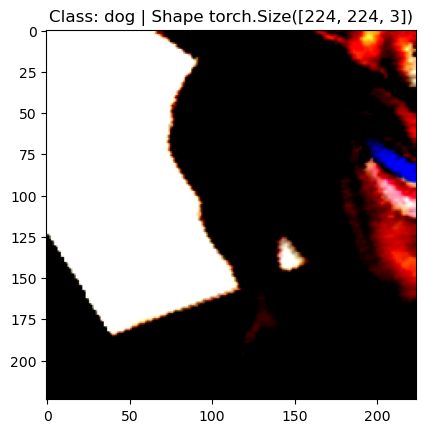

In [19]:
import random
import matplotlib.pyplot as plt
def display_random_image(
        dataset: Dataset,
        classes: List[str] = None,
):
        idx = random.sample(range(len(dataset)), k=1)
        data: Tuple[Image.Image, int] = dataset[idx[0]]
        image, target = data
        
        print(range(len(dataset)), len(dataset))
        image = image.permute(1,2,0)
        plt.imshow(image)
        plt.title(f"Class: {classes[target]} | Shape {image.shape}")

display_random_image(train_cats_dogs, train_cats_dogs.classes)

In [20]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_cats_dogs, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_cats_dogs, batch_size= 64, shuffle=True)

print(f"Train Loader: {train_loader} | Size: {len(train_loader)}")
print(f"Test Loader: {test_loader} | Size: {len(test_loader)}")
# print(next(iter(train_loader)))
print(next(iter(train_loader))[0].shape)
print(next(iter(train_loader))[0])
divider()
print(next(iter(train_loader))[1])
print(next(iter(train_loader))[1].shape)

Train Loader: <torch.utils.data.dataloader.DataLoader object at 0x000002BF199DD450> | Size: 157
Test Loader: <torch.utils.data.dataloader.DataLoader object at 0x000002BF199DE750> | Size: 125
torch.Size([64, 3, 224, 224])
tensor([[[[-1.7606, -1.7606, -1.7606,  ..., -1.7606, -1.7606, -1.7606],
          [-1.7606, -1.7606, -1.7606,  ..., -1.7606, -1.7606, -1.7606],
          [-1.7606, -1.7606, -1.7606,  ..., -1.7606, -1.7606, -1.7606],
          ...,
          [ 1.6363,  1.6225,  1.6225,  ...,  1.2358,  1.2358,  1.2635],
          [ 1.6363,  1.6087,  1.6087,  ...,  1.1944,  1.2082,  1.2497],
          [ 1.6225,  1.6225,  1.6087,  ...,  1.1530,  1.1668,  1.2220]],

         [[-1.7606, -1.7606, -1.7606,  ..., -1.7606, -1.7606, -1.7606],
          [-1.7606, -1.7606, -1.7606,  ..., -1.7606, -1.7606, -1.7606],
          [-1.7606, -1.7606, -1.7606,  ..., -1.7606, -1.7606, -1.7606],
          ...,
          [ 1.5672,  1.5534,  1.5534,  ...,  1.2773,  1.2773,  1.3049],
          [ 1.5672,  1.5396

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


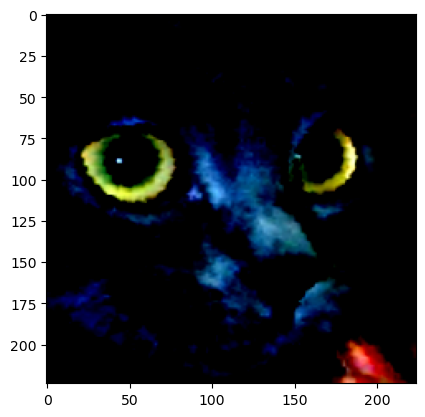

torch.Size([224, 224, 3])

In [22]:
data: Tuple[Image.Image, int] = train_cats_dogs[4562] #  __getitem__ is called
image, target = data

image = image.permute(1,2,0)
plt.imshow(image)
plt.show()
image.shape

In [44]:
from torch import nn, optim
class CatsDogsClassify(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        ) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*28*28, out_features=2)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        # print(x.shape)
        return x

model = CatsDogsClassify().to(device)    

# Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_loader))

# print(img_batch, img_batch.shape)
# print(label_batch, label_batch.shape)

img_batch[0].shape
# img_batch[0] = img_batch[0].permute(1,2,0)
# img_batch[0].shape
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
# print(f"Single image shape: {img_single.shape}\n")

model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

divider()

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")    

----------------------------------------------------
Output logits:
tensor([[0.1259, 0.0090]])

Output prediction probabilities:
tensor([[0.5292, 0.4708]])

Output prediction label:
tensor([0])

Actual label:
0


In [24]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [46]:
def train(
        model: nn.Module,
        optimizer: optim.Optimizer,
        loss_function: nn.Module,
        train_loader: DataLoader,
        test_loader: DataLoader,
        epochs: int = 10,
) -> Tuple[List, List, List]:
    epochs_count, trains_loss_arr, test_loss_arr = [], [], []
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader: # loop on batches -> images and labels
            output = model(images)
            train_loss = loss_function(output, labels)
            train_loss.backward() # this function calculates the derivative of the loss with respect to each parameter

            optimizer.step()
            optimizer.zero_grad() # it makes the derivative = zero
            test_loss = 0
        model.eval()
        for images, labels in test_loader:
            with torch.inference_mode(): # to not to calculate derivative
                output = model(images)
                test_loss = loss_function(output, labels)


        epochs_count.append(epoch)
        trains_loss_arr.append(train_loss.detach().numpy())
        test_loss_arr.append(test_loss.detach().numpy())
        epochs_count.append(epoch)     
        print(f'Epoch {epoch}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    return epochs_count, trains_loss_arr, test_loss_arr

def predict(model, data):
    with torch.inference_mode():
        output = model(data)
        predicted = torch.softmax(output, dim=1).argmax(dim=1)
        return predicted


In [ ]:
epochs_count, train_losses, test_losses = train(model, optimizer, loss_function, train_loader, test_loader, 10)

In [47]:
# !pip install torchinfo
import torchinfo
    
from torchinfo import summary
# do a test pass through of an example input size 
summary(model, input_size=[1, 3, 224 ,224]) 

Layer (type:depth-idx)                   Output Shape              Param #
CatsDogsClassify                         [1, 2]                    --
├─Sequential: 1-1                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-1                       [1, 128, 224, 224]        3,584
│    └─ReLU: 2-2                         [1, 128, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [1, 128, 224, 224]        256
│    └─MaxPool2d: 2-4                    [1, 128, 112, 112]        --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        590,336
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,